In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

path = '../week4/data/'

# Helping functions

In [61]:
def get_gauss_feat_im(im, sigma=1, normalize=True):
    """Gauss derivative feaures for every image pixel.
    Arguments:
        image: a 2D image, shape (r, c).
        sigma: standard deviation for Gaussian derivatives.
        normalize: flag indicating normalization of features.
    Returns:
        imfeat: 3D array of size (r, c, 15) with a 15-dimentional feature
             vector for every pixel in the image.
    Author: vand@dtu.dk, 2020
    """
      
    r, c = im.shape
    imfeat = np.zeros((r, c, 15))
    imfeat[:, :, 0] = scipy.ndimage.gaussian_filter(im, sigma, order=0)
    imfeat[:, :, 1] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 1])
    imfeat[:, :, 2] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 0])
    imfeat[:, :, 3] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 2])
    imfeat[:, :, 4] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 1])
    imfeat[:, :, 5] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 0])
    imfeat[:, :, 6] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 3])
    imfeat[:, :, 7] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 2])
    imfeat[:, :, 8] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 1])
    imfeat[:, :, 9] = scipy.ndimage.gaussian_filter(im, sigma, order=[3, 0])
    imfeat[:, :, 10] = scipy.ndimage.gaussian_filter(im, sigma, order=[0, 4])
    imfeat[:, :, 11] = scipy.ndimage.gaussian_filter(im, sigma, order=[1, 3])
    imfeat[:, :, 12] = scipy.ndimage.gaussian_filter(im, sigma, order=[2, 2])
    imfeat[:, :, 13] = scipy.ndimage.gaussian_filter(im, sigma, order=[3, 1])
    imfeat[:, :, 14] = scipy.ndimage.gaussian_filter(im, sigma, order=[4, 0])

    if normalize:
        imfeat -= np.mean(imfeat, axis=(0, 1))
        im_std = np.std(imfeat, axis=(0, 1))
        im_std[im_std<10e-10] = 1
        imfeat /= im_std
    
    return imfeat

def get_gauss_feat_multi(im, sigma = [1, 2, 4], normalize = True):
    '''Multi-scale Gauss derivative feaures for every image pixel.
    Arguments:
        image: a 2D image, shape (r, c).
        sigma: list of standard deviations for Gaussian derivatives.
        normalize: flag indicating normalization of features.
    Returns:
        imfeat: a a 3D array of size (r*c, n_scale, 15) with n_scale features in each pixels, and
             n_scale is length of sigma. Each pixel contains a feature vector and feature
             image is size (r, c, 15*n_scale).
    Author: abda@dtu.dk, 2021

    '''
    imfeats = []
    for i in range(0, len(sigma)):
        feat = get_gauss_feat_im(im, sigma[i], normalize)
        imfeats.append(feat.reshape(-1, feat.shape[2]))
    
    imfeats = np.asarray(imfeats).transpose(1, 0, 2)
    return imfeats


# Compute features

<Figure size 640x480 with 0 Axes>

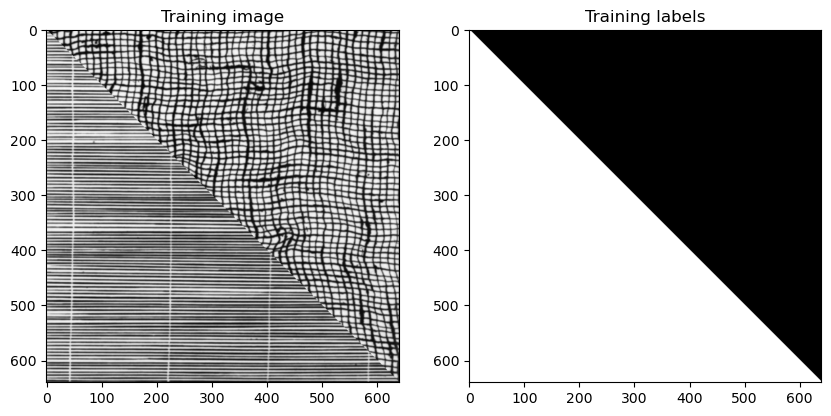

In [62]:
# Open the image
training = cv2.imread(path + '2labels/training.png', 0)
training_labels = cv2.imread(path + '2labels/training_labels.png', 0)

# Show both images
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(training, cmap='gray')
plt.title('Training image')
plt.subplot(122)
plt.imshow(training_labels, cmap='gray')
plt.title('Training labels')
plt.show()

## Get all the different features in the image (15 features at 3 scales = 45 features)

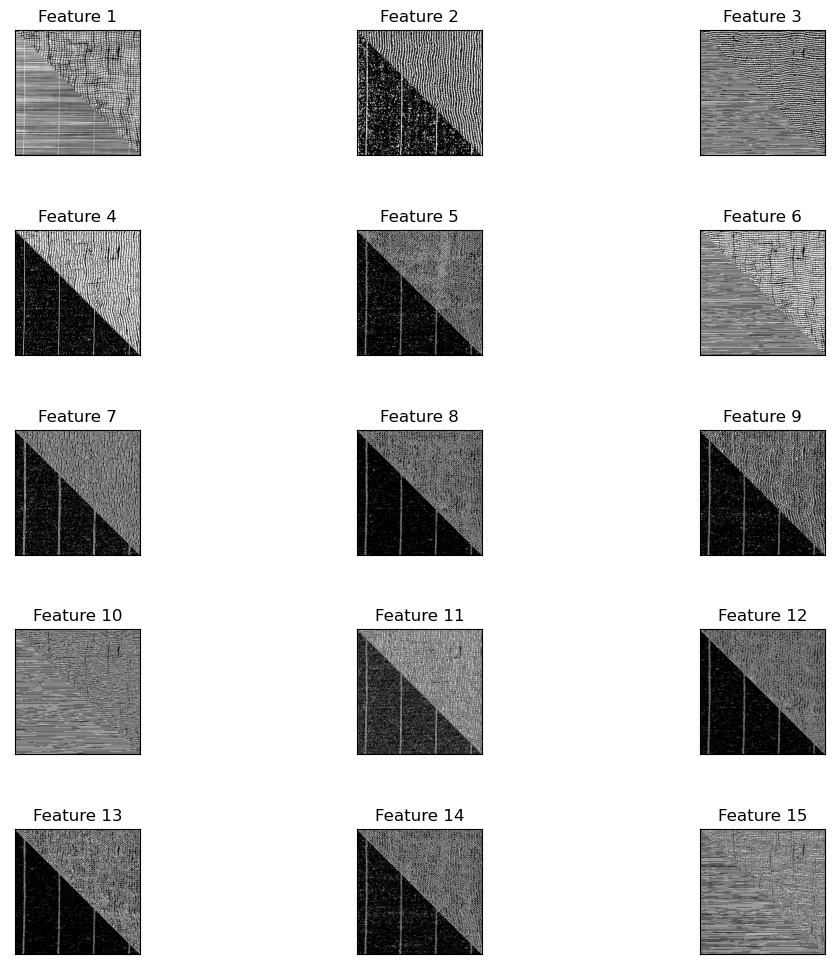

In [63]:
# Compute the features image with get_gauss_feat_multi
sigma = [1, 2, 4]
imfeats = get_gauss_feat_multi(training, sigma, True)

# Reshape the imfeats array
imfeats_reshaped = imfeats.reshape(training.shape[0], training.shape[1], -1)

# Show the different features in the image
plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i in range(min(imfeats_reshaped.shape[2], 15)):
    plt.subplot(5, 3, i+1)
    plt.imshow(imfeats_reshaped[:, :, i], cmap='gray')
    plt.title('Feature ' + str(i+1))
    plt.xticks([])
    plt.yticks([])

plt.show()

## Flatten the features image (r * c * 15n -> rc * 15n)

In [71]:
# Resize the feature image
imfeats_flattened = imfeats_reshaped.reshape(-1, imfeats_reshaped.shape[-1])

# Show the new shape
print(imfeats_flattened.shape)  # (rows*columns, 15*n_scales)


(409600, 45)


## Compute the Label Probability Image (r * c * number_unique_features)

In [72]:
unique_labels = np.unique(training_labels)  # Identify unique label
print("Unique labels: ", unique_labels)
nl = len(unique_labels)  # Number of unique labels
print("Number of unique labels: ", nl)

# Initialize the label probability image with zeros
r, c = training_labels.shape
L = np.zeros((r, c, nl))
    
# Assign 1 to the appropriate layer for each pixel
for i, label in enumerate(unique_labels):
    L[:, :, i] = (training_labels == label).astype(int)

training_labels_prob = L
print(training_labels_prob.shape)  # (rows, columns, number of unique labels)

Unique labels:  [  0 255]
Number of unique labels:  2
(640, 640, 2)


## Flatten the Label Probability Image (rc * number_unique_features)

In [73]:
# Flatten the label probability image
labels_flattened = training_labels_prob.reshape(-1, nl)
print(labels_flattened.shape)  # (rows*columns, number of unique labels)

(409600, 2)


## Build the dictionary

### Random subset

- From all the pixel in the image, get a random set of pixels.
- Get the features of those pixels and the labels of those pixels (if they are labeled as foreground or background).

In [90]:
import random

# Select a random subset of feature vectors and corresponding labels
num_samples = 5000 
indices = random.sample(range(imfeats_flattened.shape[0]), num_samples)

sample_feats = imfeats_flattened[indices]
print("Shape of sample_feats: ", sample_feats.shape)  # (num_samples, 15*n_scales)

sample_labels = labels_flattened[indices]
print("Shape of sample_labels: ", sample_labels.shape)  # (num_samples, number of unique labels)

Shape of sample_feats:  (5000, 45)
Shape of sample_labels:  (5000, 2)


### K-means clustering

- Cluster the set of 5000 pixels into 100 clusters based on how close their features are.
- Now the 100 clusters have a mean feature vector.

In [92]:
from sklearn.cluster import KMeans

num_clusters=100

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sample_feats)
cluster_centers = kmeans.cluster_centers_

print("Shape of cluster_centers: ", cluster_centers.shape)  # (num_clusters, 15*n_scales)

c:\Users\Alejandro\anaconda3\envs\course02502\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of cluster_centers:  (100, 45)


### Store label probabilities for each cluster

- For each cluster, the probability of it belonging to each label is computed. 

In [93]:
label_probs = np.zeros((num_clusters, training_labels_prob.shape[-1]))

labels_pred = kmeans.predict(sample_feats)
for i in range(num_clusters):
        cluster_indices = np.where(labels_pred == i)[0]
        if len(cluster_indices) > 0:
            cluster_labels = sample_labels[cluster_indices]
            # Compute the probability of each label within this cluster
            label_probs[i] = np.mean(cluster_labels, axis=0)


# Print a few label probabilities
print(label_probs[:5])
print("Shape of label_probs: ", label_probs.shape)  # (num_clusters, number of unique labels)


[[0.04347826 0.95652174]
 [0.04166667 0.95833333]
 [0.08823529 0.91176471]
 [0.0047619  0.9952381 ]
 [0.92857143 0.07142857]]
Shape of label_probs:  (100, 2)


# Apply to a test image

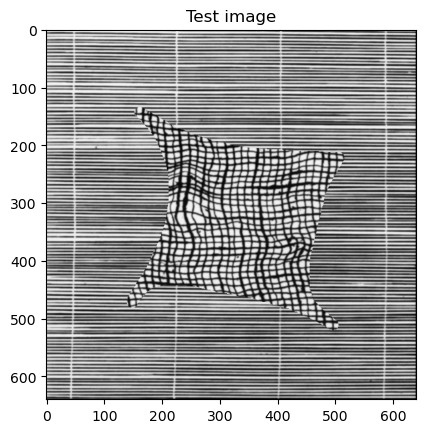

In [95]:
test_image = cv2.imread(path + '2labels/test_easy.png', 0)

# Show the test image
plt.figure()
plt.imshow(test_image, cmap='gray')
plt.title('Test image')
plt.show()

## Compute the features and flatten

In [100]:
# Compute the features for the test image
sigma = [1, 2, 4]  # Scales for Gaussian derivatives
test_imfeats = get_gauss_feat_multi(test_image, sigma, True)

# Reshape the features to have a shape of (rows, columns, 45) for visualization or further processing
test_imfeats_reshaped = test_imfeats.reshape(test_image.shape[0], test_image.shape[1], -1)
print("Shape of test_imfeats_reshaped: ", test_imfeats_reshaped.shape)  # (rows, columns, 45)

# Flatten the features to have a shape of (rows*columns, 45) for clustering
test_imfeats_flattened = test_imfeats_reshaped.reshape(-1, test_imfeats_reshaped.shape[-1])
print("Shape of test_imfeats_flattened: ", test_imfeats_flattened.shape)  # (rows*columns, 45)

Shape of test_imfeats_reshaped:  (640, 640, 45)
Shape of test_imfeats_flattened:  (409600, 45)


## Apply kmeans clustering

- Each pixel is classified into one of the 100 clusters previously created.

Shape of nearest_clusters:  (409600,)
Shape of nearest_cluster_image:  (640, 640)


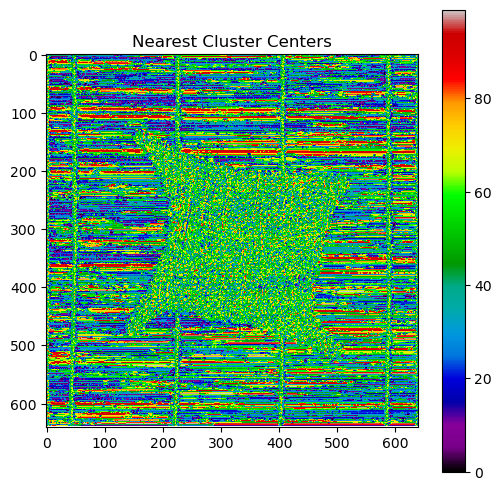

In [104]:
# Find the nearest cluster for each feature in the test image
nearest_clusters = kmeans.predict(test_imfeats_flattened)
print("Shape of nearest_clusters: ", nearest_clusters.shape)  # (rows*columns,)

# Reshape the nearest_clusters array to match the test image shape
nearest_cluster_image = nearest_clusters.reshape(test_image.shape)
print("Shape of nearest_cluster_image: ", nearest_cluster_image.shape)  # (rows, columns)

# Display the nearest cluster image
plt.figure(figsize=(6, 6))
plt.imshow(nearest_cluster_image, cmap='nipy_spectral')
plt.title('Nearest Cluster Centers')
plt.colorbar()
plt.show()


## Probability image and segmentation
- For each pixel in the test image, you look up the index of its nearest cluster center (from the assignment image you've previously created).
- You then use the label probabilities associated with that cluster center to fill in the corresponding location in the probability image.
- The segmentation is obtained by taking the maximum probability label for each pixel across the label dimension of the probability image.

Shape of probability_image:  (640, 640, 2)


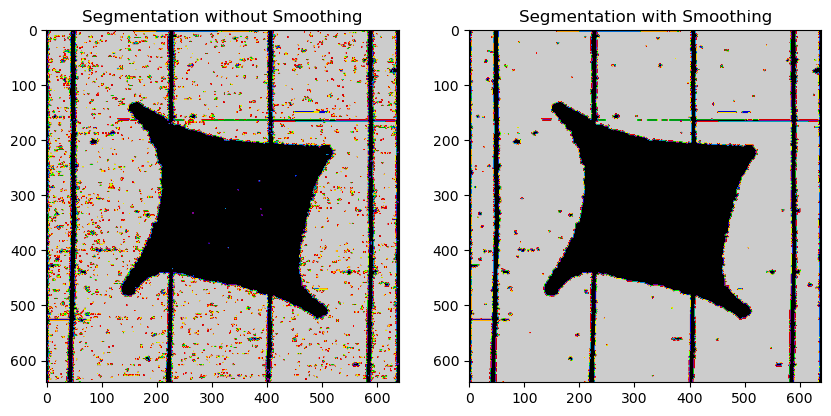

In [110]:
# Step 1: Create the probability image
r, c = test_image.shape[:2]  # Dimensions of the test image
nl = label_probs.shape[1]  # Number of labels
probability_image = np.zeros((r, c, nl))

print("Shape of probability_image: ", probability_image.shape)  # (rows, columns, number of unique labels)

# Step 2: Fill in the probability image
for i in range(r):
    for j in range(c):
        cluster_index = nearest_cluster_image[i, j]
        probability_image[i, j, :] = label_probs[cluster_index]

# Step 3: Compute the segmentation
segmentation = np.argmax(probability_image, axis=2)

# Optional Step 4: Smooth the probability image before selecting the most probable label
from scipy.ndimage import gaussian_filter
smoothed_probability_image = np.zeros_like(probability_image)
for i in range(nl):
    smoothed_probability_image[:, :, i] = gaussian_filter(probability_image[:, :, i], sigma=1)

# Recompute the segmentation based on the smoothed probability image
smoothed_segmentation = np.argmax(smoothed_probability_image, axis=2)

# Display the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(segmentation, cmap='nipy_spectral')
plt.title('Segmentation without Smoothing')
plt.subplot(1, 2, 2)
plt.imshow(smoothed_segmentation, cmap='nipy_spectral')
plt.title('Segmentation with Smoothing')
plt.show()